In [36]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
def fetch_pokemon_data(limit=151):
    """
    Fetch Pokémon data from the PokéAPI.
    Args:
        limit (int): Number of Pokémon to fetch (default: 151 for the first generation).
    Returns:
        DataFrame: Pokémon data in a Pandas DataFrame.
    """
    base_url = "https://pokeapi.co/api/v2/pokemon"
    pokemon_data = []

    for i in range(1, limit + 1):
        response = requests.get(f"{base_url}/{i}")
        if response.status_code == 200:
            data = response.json()
            
            # Extract relevant fields
            pokemon = {
                "id": data["id"],
                "name": data["name"],
                "height": data["height"],
                "weight": data["weight"],
                "base_experience": data["base_experience"],
                "types": [t["type"]["name"] for t in data["types"]],
                "abilities": [a["ability"]["name"] for a in data["abilities"]],
                "stats": {s["stat"]["name"]: s["base_stat"] for s in data["stats"]},
            }
            pokemon_data.append(pokemon)
        else:
            print(f"Failed to fetch data for Pokémon ID: {i}")

    return pd.DataFrame(pokemon_data)


In [8]:
pokemon_df = fetch_pokemon_data()

In [9]:
# Normalize 'types' into separate columns
types_df = pokemon_df["types"].apply(pd.Series).rename(columns=lambda x: f"type_{x + 1}")
pokemon_df = pd.concat([pokemon_df, types_df], axis=1).drop(columns=["types"])

# Normalize 'abilities' into separate columns
abilities_df = pokemon_df["abilities"].apply(pd.Series).rename(columns=lambda x: f"ability_{x + 1}")
pokemon_df = pd.concat([pokemon_df, abilities_df], axis=1).drop(columns=["abilities"])

# Expand 'stats' into separate columns
stats_df = pokemon_df["stats"].apply(pd.Series)
pokemon_df = pd.concat([pokemon_df, stats_df], axis=1).drop(columns=["stats"])

# Check the transformed DataFrame
pokemon_df.head()

,id,name,height,weight,base_experience,type_1,type_2,ability_1,ability_2,ability_3,hp,attack,defense,special-attack,special-defense,speed
0,1,bulbasaur,7,69,64,grass,poison,overgrow,chlorophyll,NaN,45,49,49,65,65,45
1,2,ivysaur,10,130,142,grass,poison,overgrow,chlorophyll,NaN,60,62,63,80,80,60
2,3,venusaur,20,1000,263,grass,poison,overgrow,chlorophyll,NaN,80,82,83,100,100,80
3,4,charmander,6,85,62,fire,NaN,blaze,solar-power,NaN,39,52,43,60,50,65
4,5,charmeleon,11,190,142,fire,NaN,blaze,solar-power,NaN,58,64,58,80,65,80


In [10]:
# Save to CSV for reuse
pokemon_df.to_csv("pokemon_data.csv", index=False)

In [11]:
# Replace NaN values with "None" for categorical columns
pokemon_df.fillna({"type_2": "None", "ability_2": "None", "ability_3": "None"}, inplace=True)

In [12]:
# One-hot encode categorical columns
encoded_df = pd.get_dummies(pokemon_df, columns=["type_1", "type_2", "ability_1", "ability_2", "ability_3"])


In [13]:
from sklearn.preprocessing import MinMaxScaler

# Select numeric columns to normalize
numeric_cols = ["height", "weight", "base_experience", "hp", "attack", "defense", 
                "special-attack", "special-defense", "speed"]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
pokemon_df[numeric_cols] = scaler.fit_transform(pokemon_df[numeric_cols])


In [43]:
pokemon_df.columns

Index(['id', 'name', 'height', 'weight', 'base_experience', 'type_1', 'type_2',
       'ability_1', 'ability_2', 'ability_3', 'hp', 'attack', 'defense',
       'special-attack', 'special-defense', 'speed'],
      dtype='object')

In [31]:
pokemon_data = pokemon_df.copy()

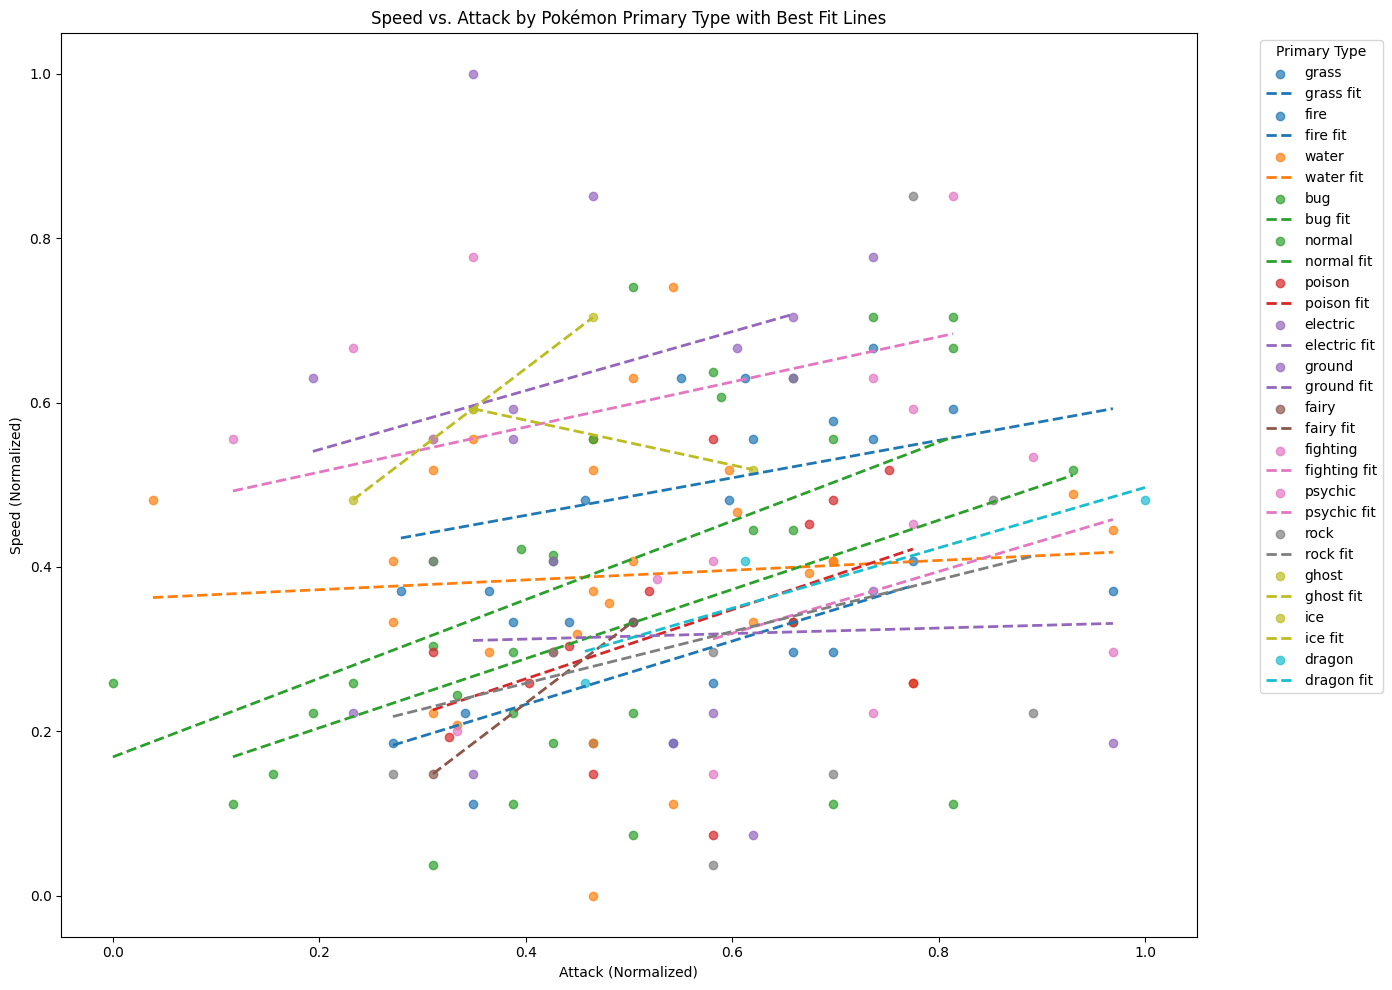

In [48]:
type_columns = [col for col in pokemon_data.columns if "type_1" in col]

if "type_1" in pokemon_data.columns:
    # Set up color mapping for primary types
    unique_types = pokemon_data["type_1"].unique()
    color_map = {ptype: plt.cm.tab10(i / len(unique_types)) for i, ptype in enumerate(unique_types)}

    # Create the scatter plot
    plt.figure(figsize=(14, 10))
    for p_type in unique_types:
        type_data = pokemon_data[pokemon_data["type_1"] == p_type]
        # Scatter plot for the current type
        plt.scatter(
            type_data["attack"],
            type_data["speed"],
            color=color_map[p_type],
            label=p_type,
            alpha=0.7
        )
        # Fit and plot regression line
        coefficients = np.polyfit(type_data["attack"], type_data["speed"], deg=1)
        poly_eq = np.poly1d(coefficients)
        x_vals = np.linspace(type_data["attack"].min(), type_data["attack"].max(), 100)
        plt.plot(
            x_vals,
            poly_eq(x_vals),
            color=color_map[p_type],
            linestyle="--",
            linewidth=2,
            label=f"{p_type} fit"
        )

    # Add titles and labels
    plt.title("Speed vs. Attack by Pokémon Primary Type with Best Fit Lines")
    plt.xlabel("Attack (Normalized)")
    plt.ylabel("Speed (Normalized)")
    plt.legend(title="Primary Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
else:
    print("The column 'type_1' does not exist in the dataset. Please check the data.")